[1] - Malha fechada com LQG ou [2] - Malha aberta: 
Entre com a malha de controle a ser simulada: 1
_____Eigenvalue______ Damping___ Frequency_
    0.8814   +0.3347j     0.1602      7.352
    0.8814   -0.3347j     0.1602      7.352
SIMULANDO MALHA DE CONTROLE
O valor de ISE calculado para a malha de controle é: 57.0076
O valor de IAE calculado para a malha de controle é: 122.1325
O valor de ISU calculado para a malha de controle é: 4599.6817
O valor de TVC calculado para a malha de controle é: 12.6222


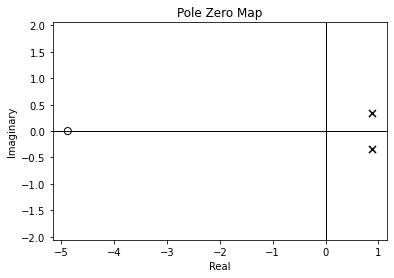

In [1]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl
from control.matlab import *
from control.statesp import *

print('[1] - Malha fechada com LQG ou [2] - Malha aberta: ') # Opções de malha de controle
n = int(input('Entre com a malha de controle a ser simulada: ')) # Seleção da malha de controle

# Configuração padrão do circuito eletrônico (modelo estocástico)
Az = [1.0, -1.7628271024278894252290683652973, 0.8888827902564973015842042514123] # Polinômio A(z^-1)
Bz = [0.021018021110895027114828792491608, 0.10254201349683352006980641135669] # Polinômio B(z^-1)
Cz = [1.0, -0.015193361616161639784938763853006, -0.0046240196648598139508856696977546] # Polinômio C(z^-1)
Ts = 0.05; d = int(1.0); umax = 5.0; umin = -5.0; # Período de amostragem, delay, limites de saturação do sinal de controle

# Transformar polinômios para numpy array
Az = np.array(Az)
Bz = np.array(Bz)
Cz = np.array(Cz)

# Coeficientes do modelo
a1 = Az[1]; a2 = Az[2]
b0 = Bz[0]; b1 = Bz[1]
c1 = Cz[1]; c2 = Cz[2]

# Ordem dos polinômios A(z^-1), B(z^-1) e C(z^-1)
na = len(Az)-1; nb = len(Bz); nc = len(Cz)-1;

# Extrair informações úteis do sistema a ser controlado
Gz = tf(Bz, Az, Ts) # Função de Transferência discreta
pole(Gz) # Polos do sistema
zero(Gz) # Zeros do sistema
pzmap(Gz) # Plota o mapa de polos e zeros do sitema
wn, csi, poles = damp(Gz) # Frequência natural, coeficiente de amortecimento e polos
# Gzss = tf2ss(Gz) # Converte o sistema em função de transferência para espaço de estado
PHI, B, C, D = ssdata(Gz) # Define as matrizes do sistema em espaço de estado

# PHI é a matriz de estados discreta
# B é a matriz de entrada discreta
# C é a matriz de saída discreta
# D é a matriz de transmissão direta

# Forma canônica controlável
PHI = np.rot90(PHI, 2) # Rotaciona a matriz em um ângulo de 90 graus 2 vezes no ssentido antihorário
G = np.flipud(B) # Flipa o vetor na direção horizontal
C = np.fliplr(C) # Flipa o vetor na direção vertical
# xsys = StateSpace(PHI, B, C, D) # Converte as matrizes para um objeto StateSpace
# zsys, _ = clt.canonical_form(xsys, form = 'observable') # Obtem o modelo na forma canônica observável
# zsys, _ = clt.observable_form(xsys) # Forma canônica observável

# Obter realização aumentada por incremento de controle em espaço de estados discreto do modelo identificado
PHI1 = np.concatenate((PHI, np.zeros([len(PHI), 1], float)), axis = 1)
PHI2 = np.concatenate((C@PHI, np.ones([1, 1], float)), axis = 1)
PHIa = np.concatenate((PHI1, PHI2), axis = 0) # Matriz de estados discreta aumentada
Ga = np.concatenate((G, C@G), axis = 0) # Matriz de entrada discreta aumentada
Ca = np.concatenate((np.zeros([1, len(PHI)], float),np.ones([1, 1], float)), axis = 1) # Matriz de saída discreta aumentada

# Projeto do compensador dinâmico LQG
# Filtro de Kalman (Observador de Estados)
Qfk = 1.0*np.identity(3, float)
Rfk = 100.0*np.ones([1, 1], float)
_ , _, L = dare(PHIa.T,Ca.T,Qfk,Rfk) # Soluciona a equação algébrica de Riccati
L = L.T # Vetor de ganhos do estimador de estados

# Regulador LQR
Qlq = 1.0*np.identity(3, float)
Rlq = np.ones([1, 1], float)
_ , _, K = dare(PHIa,Ga,Qlq,Rlq) # Soluciona a equação algébrica de Riccati
K = K # Vetor de ganhos do regulador de estados

# Malha de controle simulada
print('SIMULANDO MALHA DE CONTROLE')

# Sinal de referência
yr1 = np.zeros([1, 20], float)
yr2 = np.ones([1, 280], float)
yr3 = 3*np.ones([1, 300], float)
yr4 = 2*np.ones([1, 300], float)
yr5 = np.ones([1, 300], float)
yr = np.concatenate((yr1, yr2, yr3, yr4, yr5), axis = 1)
_, nit = yr.shape; nit = int(nit) # Número de iterações

# Perturbação na entrada da planta
v1 = np.zeros([1, 20], float)
v2 = np.zeros([1, 280], float)
v3 = np.zeros([1, 300], float)
v4 = np.zeros([1, 300], float)
v5 = np.zeros([1, 300], float)
v = np.concatenate((v1, v2, v3, v4, v5), axis = 1)

# Inicializar vetores
uv = np.zeros([1, nit], float) # Inicializar vetor de sinal interno (u+v)
yv = np.zeros([1, nit], float) # Inicializar vetor de sinal interno (y+xi)
x = np.zeros([len(PHI), nit], float) # Inicializar vetor de estados
xest = np.zeros([len(PHIa), nit], float) # Inicializar vetor de estados estimados
dx = np.zeros([len(PHI), nit], float) # Inicializar vetor de variação dos estados
xa = np.zeros([len(PHIa), nit], float) # Inicializar vetor de estados aumentado
y = np.zeros([1, nit], float) # Inicializar vetor de sinal de saída
yf = np.zeros([1, nit], float) # Inicializar vetor de sinal de saída estimada (filtrada)
u = np.zeros([1, nit], float) # Inicializar vetor de sinal de controle
du = np.zeros([1, nit], float) # Inicializar vetor de incremento de controle
e = np.zeros([1, nit], float) # Inicializar vetor de sinal de erro
eest = np.zeros([1, nit], float) # Inicializar vetor de sinal de erro estimado

# Inicializar o vetor de tempo
t = np.arange(0,nit*Ts,Ts); t = np.array(t, ndmin=2)

# Inicializar o vetor de ruído de saída
variance = 5.0*1e-3; # Variância
xi = np.random.normal(0.0, np.sqrt(variance), size = (1, nit)) # xi = np.random.normal(média, desvio padrão, número de amostras)

# Condições iniciais de simulação
for k in range(len(PHI)+int(d)):
    # Sistema nominal
    y[0, k] = 0
    x[:, k] = np.zeros([1, na], float)
    u[0, k] = 0
    # Sistema aumentado
    xest[:, k] = np.zeros([1, na+1], float)
    xa[:, k] = np.zeros([1, na+1], float)
    yf[0, k] = 0
    du[0, k] = 0    

# Malha de controle
for k in range(len(PHI)+int(d), nit):
    x[:len(x), k:k+1] = PHI@x[:len(x), k-1:k] +G*u[0, k-d] # Estados nominais
    y[0, k] = C@x[:len(x), k:k+1] # Saída da planta
    yv[0, k] = y[0, k] +xi[0, k] +v[0, k] # Sinal de saída medido
    e[0, k] = yr[0, k] -yv[0, k] # Sinal de erro
    
    if n == 1: # Malha fechada
        # Lei de controle LQG
        # Filtro de Kalman
        xa[:len(xa), k:k+1] = (PHIa-L@Ca)@xa[:len(xa), k-1:k] +Ga*du[0, k-d] +L*yv[0, k-1] # Estados aumentados
        yf[0, k] = Ca@xa[:len(xa), k:k+1] # Saída da planta aumentada
        eest[0, k] = y[0, k] -yf[0, k] # Erro de estimação
        # Regulador LQR
        # Lei de controle
        du[0, k] = -K@xa[:len(xa), k:k+1] +K[0, na]*yr[0, k] # Incremento de controle
        u[0, k] = u[0, k-1] +du[0, k] # Sinal de controle
        
    elif n == 2: # Malha aberta
        u[0, k] = yr[0, k] # Sinal de controle]
        du[0, k] = u[0, k] -u[0, k-1] # Incremento de controle
    if u[0, k] >= umax: #Saturação da lei de controle
        u[0, k] = umax;
    elif u[0, k] <= umin:
        u[0, k] = umin

# Índices de desempenho
ISE = np.sum(e @ e.T); # Integral Square Error
IAE = np.sum(np.absolute(e)); # Integral Absolute Error
ISU = np.sum(u @ u.T); # Integral Square of Control
TVC =  np.sum(np.absolute(du)); # Total Variation of Control

# Apresenta os valores calculados ao usuário
print('O valor de ISE calculado para a malha de controle é: {:.4f}'.format(ISE))
print('O valor de IAE calculado para a malha de controle é: {:.4f}'.format(IAE))
print('O valor de ISU calculado para a malha de controle é: {:.4f}'.format(ISU))
print('O valor de TVC calculado para a malha de controle é: {:.4f}'.format(TVC))

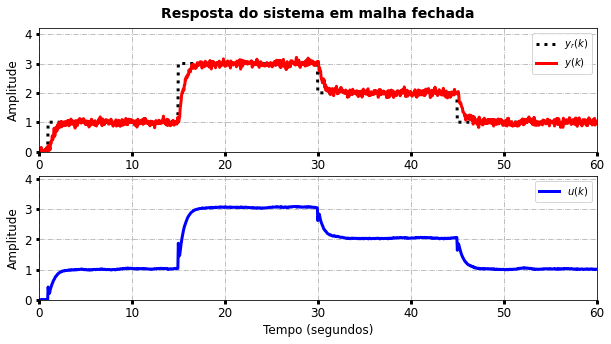

In [2]:
# Gerar gráfico e suas configurações

plt.rc(
    'axes',
    labelweight = 'normal',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
    labelcolor = 'k',
)

if n == 1: # Título para figura caso seja malha fechada
    titulo = 'Resposta do sistema em malha fechada'
elif n == 2: # Título para figura caso seja malha aberta
    titulo = 'Resposta em malha aberta'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5))
ax1.plot(t.T,yr.T,':k',t.T,yv.T,'r', linewidth = 3)
ax1.axis([0, 60, 0, np.max(yv)+1])
ax1.legend(['$y_r(k)$', '$y(k)$'])
ax1.set(ylabel = 'Amplitude', title = 'Resposta do sistema em malha fechada')
ax1.grid(True, linestyle = '-.')
ax1.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

ax2.plot(t.T,u.T,'b', linewidth = 3)
plt.axis([0, 60, 0, np.max(u)+1])
ax2.legend(['$u(k)$'])
ax2.set(ylabel = 'Amplitude', xlabel = 'Tempo (segundos)')
ax2.grid(True, linestyle = '-.')
ax2.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

fig.savefig('LQG_Control.png', dpi = 300)

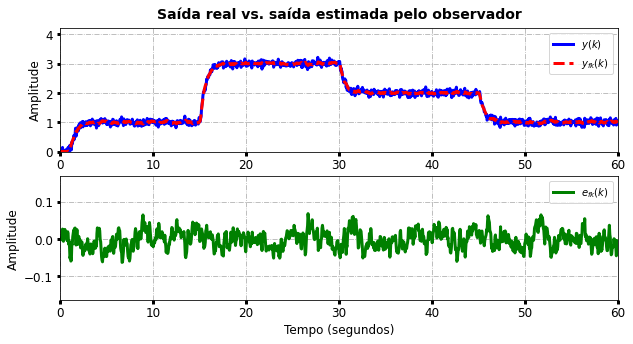

In [3]:
# Gerar gráfico e suas configurações

plt.rc(
    'axes',
    labelweight = 'normal',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
    labelcolor = 'k',
)

if n == 1: # Título para figura caso seja malha fechada
    titulo = 'Resposta do sistema em malha fechada'
elif n == 2: # Título para figura caso seja malha aberta
    titulo = 'Resposta em malha aberta'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5))
ax1.plot(t.T,yv.T,'b',t.T,yf.T,'r--', linewidth = 3)
ax1.axis([0, 60, 0, np.max(yv)+1])
ax1.legend(['$y(k)$', '$y_{fk}(k)$'])
ax1.set(ylabel = 'Amplitude', title = 'Saída real vs. saída estimada pelo observador')
ax1.grid(True, linestyle = '-.')
ax1.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

ax2.plot(t.T,eest.T,'g', linewidth = 3)
plt.axis([0, 60, np.min(eest)-0.1, np.max(eest)+0.1])
ax2.legend(['$e_{fk}(k)$'])
ax2.set(ylabel = 'Amplitude', xlabel = 'Tempo (segundos)')
ax2.grid(True, linestyle = '-.')
ax2.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

fig.savefig('LQG_Control.png', dpi = 300)

In [4]:
dados = {'yr': list(yr.T), 'u': list(u.T), 'y': list(yv.T), 't': list(t.T)} # Salvar os sinais de interesse
lqg_df = pd.DataFrame(data = dados) # Criar o dataframe
lqg_df.to_excel('LQG Dados.xlsx', index = False) # Salvar o dataframe em formato de arquivo Excel no computador
# lqg_df.to_csv('LQG Dados.csv', index = False) # Salvar o dataframe em formato de arquivo CSV no computador

In [5]:
lqg_df = pd.read_excel('LQG Dados.xlsx') # Carregar os dados contidos na tabela do Excel
display(lqg_df.tail(10)) # Apresentar ao usuário os 10 últimos valores de cada sinal coletado

,yr,u,y,t
1190,[1.],[1.00950167],[0.90493234],[59.5]
1191,[1.],[1.01680501],[1.08036398],[59.55]
1192,[1.],[1.00647822],[1.00367499],[59.6]
1193,[1.],[1.00734534],[0.95494013],[59.65]
1194,[1.],[1.01231937],[1.09901458],[59.7]
1195,[1.],[1.00372839],[1.12907291],[59.75]
1196,[1.],[0.99907436],[0.90173663],[59.8]
1197,[1.],[1.01518128],[0.98088871],[59.85]
1198,[1.],[1.01422358],[0.94495315],[59.9]
1199,[1.],[1.01193662],[1.03863359],[59.95]
